In [6]:
# Assignment 3
# Part 1 a, b

# from https://stackoverflow.com/questions/66924232/reshaping-mnist-for-resnet50
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# https://www.kaggle.com/namansood/resnet50-training-on-mnist-transfer-learning

import sys
import os
from matplotlib import pyplot
import numpy as np
from numpy import copy
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize_local_mean

NN = ['resnet50', 'vgg19']
LEARNING_RATE = 0.01
LOSS_METHOD = 'categorical_crossentropy'
MAX_EPOCH = 35
TRAIN_SIZE = [10, 30, 50, 70, 90]
TEST_SIZE = int(5000/10)

def load_dataset(ts):
    (trainX, trainY), (testX, testY) = tf.keras.datasets.mnist.load_data()
    trainX, trainY = custom_dataset(trainX, trainY, ts)
    trainY = to_categorical(trainY)
    testX, testY = custom_dataset(testX, testY, TEST_SIZE)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def prep_pixels(train, test):
    train_norm = np.expand_dims(train, axis=-1)
    train_norm = np.repeat(train_norm, 3, axis=-1)
    test_norm = np.expand_dims(test, axis=-1)
    test_norm = np.repeat(test_norm, 3, axis=-1)
    
    train_norm = train_norm.astype('float32')
    test_norm = test_norm.astype('float32')
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    return train_norm, test_norm

def sort_dataset(dataX, dataY):
    categories = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: [],
        7: [],
        8: [],
        9: []
    }
    for i in range(0, dataY.size):
        categories[dataY[i]].append(dataX[i])
    return categories

def custom_dataset(trainX, trainY, size):
    sorted_data = sort_dataset(trainX, trainY)
    trainX_cust = []
    trainY_cust = []
    for label, features in sorted_data.items():
        for j in range(0, size):
            trainY_cust.append(label)
            trainX_cust.append(features[j])
    trainX_cust = np.array(trainX_cust)
    trainY_cust = np.array(trainY_cust)
    return trainX_cust, trainY_cust

def scale_data(train, test, nn):
    print(f"resizing data for {nn}")
    train_scaled = []
    test_scaled = []
    if (nn == NN[0]):
        for image in train:
            train_scaled.append(resize_local_mean(image, (32,32)))
        for image in test:
            test_scaled.append(resize_local_mean(image, (32,32)))
    if (nn == NN[1]):
        for image in train:
            train_scaled.append(resize_local_mean(image, (224,224)))
        for image in test:
            test_scaled.append(resize_local_mean(image, (224,224)))
    train_scaled = np.array(train_scaled)
    test_scaled = np.array(test_scaled)
    return train_scaled, test_scaled

def define_model(nn):
    model = Sequential()
    if (nn == NN[0]):
        #input_t = tf.keras.Input(shape=(32, 32, 3))
        model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
    if (nn == NN[1]):
        #input_t = tf.keras.Input(shape=(224, 224, 3))
        model.add(VGG19(include_top=False, pooling='avg', weights='imagenet'))
    model.add(Dense(10, activation='softmax'))
    model.layers[0].trainable = False
    model.summary()
    opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)
    #opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, loss=LOSS_METHOD, metrics=['accuracy'])
    return model
    
def summarize_diagnostics(history, nn, ts, acc):
    # list all data in history
    #print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['accuracy'])
    pyplot.plot(history.history['val_accuracy'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    # save plot to file
    filename = './plots/' + nn + '-' + str(ts) + '-acc_' + acc
    pyplot.savefig(filename + '-accplot.png')
    pyplot.close()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    # save plot to file
    pyplot.savefig(filename + '-lossplot.png')
    pyplot.close()   
    
def run_test_harness(ts, nn):
    trainX, trainY, testX, testY = load_dataset(ts)
    trainX, testX = prep_pixels(trainX, testX)
    trainX, testX = scale_data(trainX, testX, nn)
    model = define_model(nn)
    history = model.fit(trainX, trainY, 
                        batch_size=4, 
                        epochs=MAX_EPOCH, 
                        validation_data=(testX, testY),
                        verbose=1)
    _, acc = model.evaluate(testX, testY, verbose=0)
    acc_string = f'{(acc*100.0):.2f}'
    print(f'Accuracy: {acc_string}')
    filepath = './models/' + nn + '-' + str(ts) + '-model'
    model.save(filepath)
    summarize_diagnostics(history, nn, ts, acc_string)

for nn in NN:
    for size in TRAIN_SIZE:
        filepath = './models/' + nn + '-' + str(size) + '-model'
        print(f"\n=====Training {nn} with set size {size}*10=====")
        if os.path.exists(filepath) == False:    
            run_test_harness(size, nn)
        else:
            print('Model already created, moving on')
        


=====Training resnet50 with set size 10*10=====
resizing data for resnet50
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_11 (Dense)            (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/35


2022-02-22 02:50:29.683396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


24/25 [===========================>..] - ETA: 0s - loss: 37.8054 - accuracy: 0.1250

2022-02-22 02:50:31.149818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 23s 903ms/step - loss: 39.5809 - accuracy: 0.1300 - val_loss: 64.1162 - val_accuracy: 0.1730
Epoch 2/35
25/25 [==============================] - 21s 862ms/step - loss: 45.0898 - accuracy: 0.1800 - val_loss: 45.9378 - val_accuracy: 0.1000
Epoch 3/35
25/25 [==============================] - 21s 857ms/step - loss: 37.3238 - accuracy: 0.2900 - val_loss: 15.2590 - val_accuracy: 0.2910
Epoch 4/35
25/25 [==============================] - 20s 852ms/step - loss: 25.5518 - accuracy: 0.3200 - val_loss: 23.7347 - val_accuracy: 0.3032
Epoch 5/35
25/25 [==============================] - 21s 856ms/step - loss: 33.2789 - accuracy: 0.2300 - val_loss: 46.0456 - val_accuracy: 0.2810
Epoch 6/35
25/25 [==============================] - 20s 849ms/step - loss: 39.5855 - accuracy: 0.3300 - val_loss: 38.8323 - val_accuracy: 0.1988
Epoch 7/35
25/25 [==============================] - 20s 852ms/step - loss: 28.6353 - accuracy: 0.3400 - val_loss: 16.8383 - val_accuracy: 0.3

2022-02-22 03:02:25.248470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 55.20
INFO:tensorflow:Assets written to: ./models/resnet50-10-model/assets


/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



=====Training resnet50 with set size 30*10=====
resizing data for resnet50
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_12 (Dense)            (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/35


2022-02-22 03:02:48.158520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 48.2160 - accuracy: 0.1500

2022-02-22 03:02:50.636496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 24s 304ms/step - loss: 48.2160 - accuracy: 0.1500 - val_loss: 45.3094 - val_accuracy: 0.2840
Epoch 2/35
75/75 [==============================] - 22s 291ms/step - loss: 30.7882 - accuracy: 0.3067 - val_loss: 25.4223 - val_accuracy: 0.3596
Epoch 3/35
75/75 [==============================] - 21s 289ms/step - loss: 31.3647 - accuracy: 0.3767 - val_loss: 20.9754 - val_accuracy: 0.3384
Epoch 4/35
75/75 [==============================] - 21s 290ms/step - loss: 27.2942 - accuracy: 0.3767 - val_loss: 40.6331 - val_accuracy: 0.3724
Epoch 5/35
75/75 [==============================] - 21s 288ms/step - loss: 31.2617 - accuracy: 0.3800 - val_loss: 27.0671 - val_accuracy: 0.4480
Epoch 6/35
75/75 [==============================] - 21s 288ms/step - loss: 21.5798 - accuracy: 0.4967 - val_loss: 16.2957 - val_accuracy: 0.4134
Epoch 7/35
75/75 [==============================] - 21s 285ms/step - loss: 27.9311 - accuracy: 0.4367 - val_loss: 25.1709 - val_accuracy: 0.4

2022-02-22 03:15:20.836254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 69.10
INFO:tensorflow:Assets written to: ./models/resnet50-30-model/assets


/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



=====Training resnet50 with set size 50*10=====
resizing data for resnet50
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_13 (Dense)            (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/35


2022-02-22 03:15:44.212391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 40.3788 - accuracy: 0.1920

2022-02-22 03:15:47.456818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 25s 187ms/step - loss: 40.3788 - accuracy: 0.1920 - val_loss: 18.8184 - val_accuracy: 0.3576
Epoch 2/35
125/125 [==============================] - 22s 178ms/step - loss: 32.3024 - accuracy: 0.3500 - val_loss: 32.3637 - val_accuracy: 0.3222
Epoch 3/35
125/125 [==============================] - 22s 178ms/step - loss: 29.9802 - accuracy: 0.3940 - val_loss: 12.5433 - val_accuracy: 0.5202
Epoch 4/35
125/125 [==============================] - 22s 177ms/step - loss: 25.4789 - accuracy: 0.4340 - val_loss: 25.7802 - val_accuracy: 0.5176
Epoch 5/35
125/125 [==============================] - 22s 177ms/step - loss: 22.4312 - accuracy: 0.4700 - val_loss: 27.0074 - val_accuracy: 0.4554
Epoch 6/35
125/125 [==============================] - 22s 178ms/step - loss: 24.4962 - accuracy: 0.4840 - val_loss: 39.1157 - val_accuracy: 0.5172
Epoch 7/35
125/125 [==============================] - 22s 177ms/step - loss: 23.2966 - accuracy: 0.5100 - val_loss: 58.6427 - val

2022-02-22 03:28:42.758106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 65.74
INFO:tensorflow:Assets written to: ./models/resnet50-50-model/assets


/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



=====Training resnet50 with set size 70*10=====
resizing data for resnet50
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_14 (Dense)            (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/35


2022-02-22 03:29:07.260985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - ETA: 0s - loss: 42.3650 - accuracy: 0.2071

2022-02-22 03:29:11.331474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 26s 138ms/step - loss: 42.3650 - accuracy: 0.2071 - val_loss: 39.5973 - val_accuracy: 0.3862
Epoch 2/35
175/175 [==============================] - 23s 132ms/step - loss: 32.0028 - accuracy: 0.3643 - val_loss: 31.4207 - val_accuracy: 0.2622
Epoch 3/35
175/175 [==============================] - 23s 132ms/step - loss: 26.9052 - accuracy: 0.4386 - val_loss: 50.1368 - val_accuracy: 0.4188
Epoch 4/35
175/175 [==============================] - 23s 132ms/step - loss: 28.8624 - accuracy: 0.4600 - val_loss: 28.3587 - val_accuracy: 0.3804
Epoch 5/35
175/175 [==============================] - 23s 132ms/step - loss: 18.0667 - accuracy: 0.5286 - val_loss: 44.8911 - val_accuracy: 0.3784
Epoch 6/35
175/175 [==============================] - 23s 133ms/step - loss: 26.9216 - accuracy: 0.4943 - val_loss: 37.8392 - val_accuracy: 0.3086
Epoch 7/35
175/175 [==============================] - 23s 132ms/step - loss: 26.8321 - accuracy: 0.5171 - val_loss: 19.5057 - val

2022-02-22 03:42:44.486668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 67.80
INFO:tensorflow:Assets written to: ./models/resnet50-70-model/assets


/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



=====Training resnet50 with set size 90*10=====
resizing data for resnet50
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_15 (Dense)            (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/35


2022-02-22 03:43:09.742068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - ETA: 0s - loss: 32.4825 - accuracy: 0.2478

2022-02-22 03:43:15.052477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 28s 116ms/step - loss: 32.4825 - accuracy: 0.2478 - val_loss: 38.7227 - val_accuracy: 0.3574
Epoch 2/35
225/225 [==============================] - 24s 109ms/step - loss: 27.6112 - accuracy: 0.3800 - val_loss: 22.0369 - val_accuracy: 0.4170
Epoch 3/35
225/225 [==============================] - 25s 109ms/step - loss: 29.1902 - accuracy: 0.4078 - val_loss: 62.7234 - val_accuracy: 0.3084
Epoch 4/35
225/225 [==============================] - 24s 109ms/step - loss: 28.0497 - accuracy: 0.4744 - val_loss: 23.3260 - val_accuracy: 0.5548
Epoch 5/35
225/225 [==============================] - 24s 109ms/step - loss: 17.3151 - accuracy: 0.5556 - val_loss: 12.6976 - val_accuracy: 0.5756
Epoch 6/35
225/225 [==============================] - 24s 108ms/step - loss: 21.7441 - accuracy: 0.5211 - val_loss: 16.7357 - val_accuracy: 0.5560
Epoch 7/35
225/225 [==============================] - 24s 107ms/step - loss: 19.3876 - accuracy: 0.5756 - val_loss: 15.7907 - val

2022-02-22 03:57:34.357962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 70.00
INFO:tensorflow:Assets written to: ./models/resnet50-90-model/assets


/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



=====Training vgg19 with set size 10*10=====
resizing data for vgg19
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_16 (Dense)            (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/35


2022-02-22 03:58:02.417229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 2.8838 - accuracy: 0.0500

2022-02-22 03:58:06.518233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 126s 5s/step - loss: 2.8838 - accuracy: 0.0500 - val_loss: 2.9262 - val_accuracy: 0.1000
Epoch 2/35
25/25 [==============================] - 130s 5s/step - loss: 3.6300 - accuracy: 0.0900 - val_loss: 3.5958 - val_accuracy: 0.1000
Epoch 3/35
25/25 [==============================] - 134s 6s/step - loss: 3.1688 - accuracy: 0.1200 - val_loss: 3.3372 - val_accuracy: 0.1000
Epoch 4/35
25/25 [==============================] - 140s 6s/step - loss: 3.1637 - accuracy: 0.1100 - val_loss: 3.4826 - val_accuracy: 0.1000
Epoch 5/35
25/25 [==============================] - 141s 6s/step - loss: 3.5772 - accuracy: 0.0900 - val_loss: 3.5372 - val_accuracy: 0.1000
Epoch 6/35
25/25 [==============================] - 144s 6s/step - loss: 3.0417 - accuracy: 0.1200 - val_loss: 2.9474 - val_accuracy: 0.1000
Epoch 7/35
25/25 [==============================] - 149s 6s/step - loss: 2.7752 - accuracy: 0.1600 - val_loss: 3.8263 - val_accuracy: 0.1000
Epoch 8/35
25/25 [======

2022-02-22 05:23:53.994214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 10.00
INFO:tensorflow:Assets written to: ./models/vgg19-10-model/assets

=====Training vgg19 with set size 30*10=====
resizing data for vgg19
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_17 (Dense)            (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/35


2022-02-22 05:26:21.064343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 2.8205 - accuracy: 0.1067

2022-02-22 05:26:29.545720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 147s 2s/step - loss: 2.8205 - accuracy: 0.1067 - val_loss: 3.3775 - val_accuracy: 0.1000
Epoch 2/35
75/75 [==============================] - 149s 2s/step - loss: 2.9855 - accuracy: 0.1233 - val_loss: 3.7477 - val_accuracy: 0.1000
Epoch 3/35
75/75 [==============================] - 149s 2s/step - loss: 2.9130 - accuracy: 0.1733 - val_loss: 3.2146 - val_accuracy: 0.1000
Epoch 4/35
75/75 [==============================] - 149s 2s/step - loss: 2.7174 - accuracy: 0.2067 - val_loss: 4.9644 - val_accuracy: 0.1000
Epoch 5/35
75/75 [==============================] - 149s 2s/step - loss: 2.6464 - accuracy: 0.2233 - val_loss: 4.0917 - val_accuracy: 0.1000
Epoch 6/35
75/75 [==============================] - 150s 2s/step - loss: 2.3486 - accuracy: 0.2333 - val_loss: 3.8208 - val_accuracy: 0.1000
Epoch 7/35
75/75 [==============================] - 149s 2s/step - loss: 2.4170 - accuracy: 0.2900 - val_loss: 5.6958 - val_accuracy: 0.1000
Epoch 8/35
75/75 [======

2022-02-22 06:51:41.199358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 10.00
INFO:tensorflow:Assets written to: ./models/vgg19-30-model/assets

=====Training vgg19 with set size 50*10=====
resizing data for vgg19
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_18 (Dense)            (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/35


2022-02-22 06:54:00.666280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 3.2623 - accuracy: 0.1100

2022-02-22 06:54:13.859619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 146s 1s/step - loss: 3.2623 - accuracy: 0.1100 - val_loss: 4.5333 - val_accuracy: 0.1000
Epoch 2/35
125/125 [==============================] - 148s 1s/step - loss: 3.4876 - accuracy: 0.1780 - val_loss: 5.6257 - val_accuracy: 0.1000
Epoch 3/35
125/125 [==============================] - 149s 1s/step - loss: 2.8985 - accuracy: 0.2140 - val_loss: 5.1577 - val_accuracy: 0.1000
Epoch 4/35
125/125 [==============================] - 149s 1s/step - loss: 2.5001 - accuracy: 0.2600 - val_loss: 4.9844 - val_accuracy: 0.1000
Epoch 5/35
125/125 [==============================] - 149s 1s/step - loss: 2.1049 - accuracy: 0.3240 - val_loss: 5.5251 - val_accuracy: 0.1000
Epoch 6/35
125/125 [==============================] - 148s 1s/step - loss: 2.1032 - accuracy: 0.3460 - val_loss: 5.1096 - val_accuracy: 0.1000
Epoch 7/35
125/125 [==============================] - 148s 1s/step - loss: 2.0162 - accuracy: 0.3460 - val_loss: 6.9340 - val_accuracy: 0.1000
Epoch 8/35

2022-02-22 08:20:04.872389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 10.00
INFO:tensorflow:Assets written to: ./models/vgg19-50-model/assets

=====Training vgg19 with set size 70*10=====
resizing data for vgg19
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_19 (Dense)            (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/35


2022-02-22 08:22:22.741078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - ETA: 0s - loss: 3.1949 - accuracy: 0.1214

2022-02-22 08:22:40.781587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 150s 857ms/step - loss: 3.1949 - accuracy: 0.1214 - val_loss: 4.0682 - val_accuracy: 0.1000
Epoch 2/35
175/175 [==============================] - 152s 872ms/step - loss: 2.8912 - accuracy: 0.1914 - val_loss: 4.2905 - val_accuracy: 0.1000
Epoch 3/35
175/175 [==============================] - 152s 870ms/step - loss: 2.3762 - accuracy: 0.2457 - val_loss: 3.9260 - val_accuracy: 0.1000
Epoch 4/35
175/175 [==============================] - 152s 872ms/step - loss: 2.4193 - accuracy: 0.2900 - val_loss: 5.4457 - val_accuracy: 0.1000
Epoch 5/35
175/175 [==============================] - 151s 868ms/step - loss: 2.1784 - accuracy: 0.3357 - val_loss: 6.6842 - val_accuracy: 0.1000
Epoch 6/35
175/175 [==============================] - 151s 868ms/step - loss: 2.1673 - accuracy: 0.3786 - val_loss: 6.2281 - val_accuracy: 0.1000
Epoch 7/35
175/175 [==============================] - 152s 871ms/step - loss: 1.9746 - accuracy: 0.3986 - val_loss: 6.6994 - val_accura

2022-02-22 09:50:25.678309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 10.00
INFO:tensorflow:Assets written to: ./models/vgg19-70-model/assets

=====Training vgg19 with set size 90*10=====
resizing data for vgg19
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_20 (Dense)            (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/35


2022-02-22 09:52:43.212210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - ETA: 0s - loss: 3.0436 - accuracy: 0.1367

2022-02-22 09:53:06.167135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 153s 682ms/step - loss: 3.0436 - accuracy: 0.1367 - val_loss: 3.9254 - val_accuracy: 0.1000
Epoch 2/35
225/225 [==============================] - 156s 696ms/step - loss: 2.6272 - accuracy: 0.2144 - val_loss: 3.9630 - val_accuracy: 0.1000
Epoch 3/35
225/225 [==============================] - 156s 697ms/step - loss: 2.1946 - accuracy: 0.3089 - val_loss: 5.2673 - val_accuracy: 0.1000
Epoch 4/35
225/225 [==============================] - 156s 696ms/step - loss: 2.1522 - accuracy: 0.3200 - val_loss: 7.4748 - val_accuracy: 0.1000
Epoch 5/35
225/225 [==============================] - 156s 694ms/step - loss: 2.0236 - accuracy: 0.3744 - val_loss: 6.1530 - val_accuracy: 0.1000
Epoch 6/35
225/225 [==============================] - 156s 694ms/step - loss: 1.9568 - accuracy: 0.3822 - val_loss: 7.9112 - val_accuracy: 0.1000
Epoch 7/35
225/225 [==============================] - 155s 692ms/step - loss: 1.6924 - accuracy: 0.4611 - val_loss: 7.0713 - val_accura

2022-02-22 11:23:18.934162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 10.00
INFO:tensorflow:Assets written to: ./models/vgg19-90-model/assets


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290143
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.789952


/Users/mucky/miniforge3/envs/assignment2/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4347, Accuracy: 8618/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.011969
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.307403

Test set: Average loss: 0.1145, Accuracy: 9658/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.404619
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.282111

Test set: Average loss: 0.0907, Accuracy: 9728/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.298164
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.252299

Test set: Average loss: 0.1245, Accuracy: 9636/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.219184
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.117661

Test set: Average loss: 0.0702, Accuracy: 9787/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.187780
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.072611

Test set: Average loss: 0.0723, Accuracy: 9774/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.225122
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.171317

Test set: Average loss: 0.0703, Accuracy: 9788/10000 (98%)

Tra

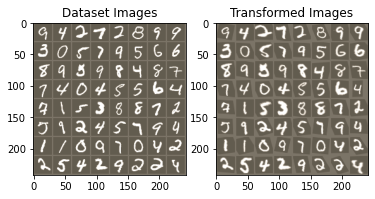

In [1]:
# Assignment 3
# Part 2 - 1

# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
        
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

In [4]:
import sys
!{sys.executable} -m pip install elasticdeform

  Preparing metadata (setup.py) ... done
  Created wheel for elasticdeform: filename=elasticdeform-0.4.9-cp38-cp38-macosx_11_0_arm64.whl size=33362 sha256=aefed0b57837d1b6c2b991d3f9af37a3740eda16044f4ac796e5beb081921028
  Stored in directory: /Users/mucky/Library/Caches/pip/wheels/a2/6c/8e/c8cbecf207f271cfd51f64f9bc6cb6fece7ca10869703f4478
Successfully built elasticdeform


In [70]:
import sys
!{sys.executable} -m pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 34.6 MB/s eta 0:00:0000:0100:01


Train Epoch: 1 [0/180000 (0%)]	Loss: 2.309483
Train Epoch: 1 [32000/180000 (18%)]	Loss: 2.228066
Train Epoch: 1 [64000/180000 (36%)]	Loss: 2.085728
Train Epoch: 1 [96000/180000 (53%)]	Loss: 1.844353
Train Epoch: 1 [128000/180000 (71%)]	Loss: 1.693766
Train Epoch: 1 [160000/180000 (89%)]	Loss: 1.598768

Test set: Average loss: 1.5044, Accuracy: 15445/30000 (51%)

Train Epoch: 2 [0/180000 (0%)]	Loss: 1.520145
Train Epoch: 2 [32000/180000 (18%)]	Loss: 1.747876
Train Epoch: 2 [64000/180000 (36%)]	Loss: 1.534384
Train Epoch: 2 [96000/180000 (53%)]	Loss: 1.265914
Train Epoch: 2 [128000/180000 (71%)]	Loss: 1.248802
Train Epoch: 2 [160000/180000 (89%)]	Loss: 1.234543

Test set: Average loss: 1.2027, Accuracy: 17096/30000 (57%)

Train Epoch: 3 [0/180000 (0%)]	Loss: 1.386402
Train Epoch: 3 [32000/180000 (18%)]	Loss: 1.033140
Train Epoch: 3 [64000/180000 (36%)]	Loss: 1.067879
Train Epoch: 3 [96000/180000 (53%)]	Loss: 1.076336
Train Epoch: 3 [128000/180000 (71%)]	Loss: 1.079480
Train Epoch: 3 [160

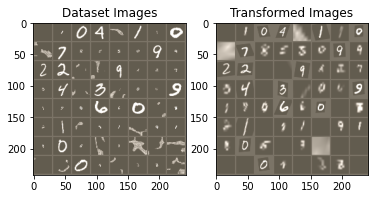

In [7]:
# Assignment 3
# Part 2 - 2

# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import elasticdeform
from torch.utils.data import Dataset, DataLoader, ConcatDataset

plt.ion()   # interactive mode

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _data_deform(x):
    return elasticdeform.deform_random_grid(np.array(x), sigma=25, points=3)

def _data_zoom(x):
    return elasticdeform.deform_grid(np.array(x), np.full((2, 3, 3), 0), prefilter=False, zoom=.25)

# Adapted from Reid's code
train_original_dataset = datasets.MNIST(
    root='.', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

train_deform_dataset = datasets.MNIST(
    root='.', train=True, download=True, transform=transforms.Compose([
        transforms.Lambda(_data_deform),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

train_zoom_dataset = datasets.MNIST(
    root='.', train=True, download=True, transform=transforms.Compose([
        transforms.Lambda(_data_zoom),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

test_original_dataset = datasets.MNIST(
    root='.', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

test_deform_dataset = datasets.MNIST(
    root='.', train=False, download=True, transform=transforms.Compose([
        transforms.Lambda(_data_deform),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

test_zoom_dataset = datasets.MNIST(
    root='.', train=False, download=True, transform=transforms.Compose([
        transforms.Lambda(_data_zoom),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

train_set = ConcatDataset([train_original_dataset, train_deform_dataset, train_zoom_dataset])
test_set = ConcatDataset([test_original_dataset, test_deform_dataset, test_zoom_dataset])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=0)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
        
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()